# Import Library

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt
import keras

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.applications import inception_v3
from keras.layers import GlobalAveragePooling2D

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [ ]:
data_dir = '/content/drive/MyDrive/Data/The IQ-OTHNCCD lung cancer dataset'

categories = ['begin', 'malignants', 'normal']

def preprocess_image(file_path):
    img = cv2.imread(file_path, 0)
    img = cv2.resize(img, (32, 32))
    img = img / 255.0  # Chuẩn hóa pixel trong khoảng [0, 1]
    return img

data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        img = preprocess_image(file_path)
        data.append(img)
        labels.append(label)

data, labels = shuffle(data, labels, random_state=42)

# Kiểm tra cân bằng dữ liệu
print('Data length:', len(data))
print('labels counts:', Counter(labels))

# normalize
X = np.array(data).reshape(-1, 32, 32, 1)
y = np.array(labels)

Data length: 1097
labels counts: Counter({1: 561, 2: 416, 0: 120})


In [ ]:
X_fold, X_valid, y_fold, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)
# X,y valid are used for evaluate matrix

print('Train length:', len(X_fold), X_fold.shape)
print('Valid length:', len(X_valid), X_valid.shape)

Train length: 767 (767, 32, 32, 1)
Test length: 330 (330, 32, 32, 1)


## Build Lenet-5 Model

In [ ]:
def Lenet5(input_shape=(32,32,1)):
        # Input
        inp = Input(input_shape)
        # Conv1
        x = Conv2D(6, 5, activation='tanh')(inp)
        # Average Pooling 1
        x = AveragePooling2D(2, 2)(x)
        # Conv2
        x = Conv2D(16, 5, activation='tanh')(x)
        # Average Pooling 2
        x = AveragePooling2D(2, 2)(x)
        # Conv3
        x = Conv2D(120, 5, activation='tanh')(x)
        x = Flatten()(x)
        # Fully connected
        x = Dense(84, activation='tanh')(x)
        # Output
        x = Dense(3, activation='softmax')(x)

        model = Model(inputs= inp, outputs=x)
        return model

model_lenet5 = Lenet5()
model_lenet5.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_4 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_32 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_5 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_33 (Conv2D)          (None, 1, 1, 120)         481

## Compile model

In [ ]:
model_lenet5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Traning model

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=3)
history_lenet5 = keras.src.callbacks
model_accuracy = []
valid_accuracy = []
model_loss = []
valid_loss = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
for train_index, test_index in kf.split(X_fold):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_fold[train_index], X_fold[test_index]
    y_train, y_test = y_fold[train_index], y_fold[test_index]
    train_generator = train_datagen.flow(X_fold, y_fold, batch_size=16, shuffle=True)
    validation_generator = val_datagen.flow(X_test, y_test, batch_size=16, shuffle=True)
    # Initialize the model
    history_lenet5 = model_lenet5.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])
    model_accuracy.extend(history_lenet5.history['accuracy'])
    valid_accuracy.extend(history_lenet5.history['val_accuracy'])
    model_loss.extend(history_lenet5.history['loss'])
    valid_loss.extend(history_lenet5.history['val_loss'])


## Model Evaluation

In [ ]:
y_pred = model_lenet5.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        39
           1       0.99      0.98      0.99       180
           2       0.97      0.95      0.96       111

    accuracy                           0.97       330
   macro avg       0.96      0.98      0.97       330
weighted avg       0.97      0.97      0.97       330

[[ 39   0   0]
 [  0 177   3]
 [  4   2 105]]


## Model visualization

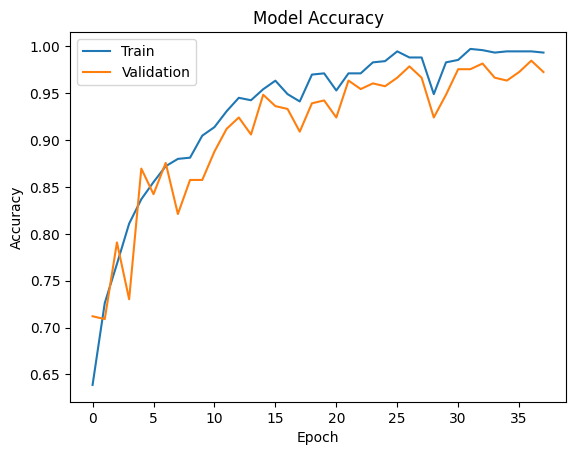

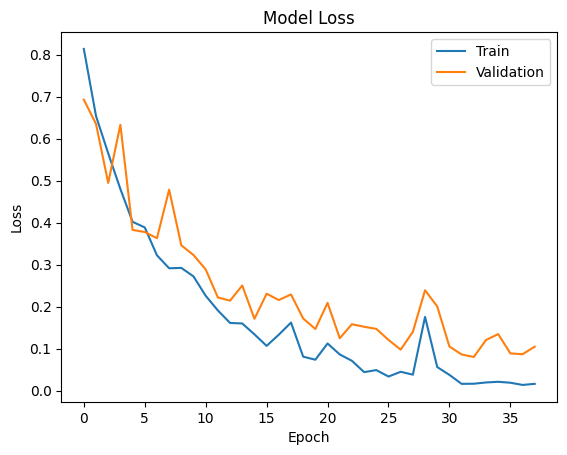

In [ ]:
plt.plot(model_accuracy, label='Train')
plt.plot(valid_accuracy, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(model_loss, label='Train')
plt.plot(valid_loss, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()